# Convolutional Networks

Convolutional networks are neural networks that are tailor-made for **visual data**. That is, 3-D (or higher) tensors

*Recall: Regular Neural Nets*. As we saw in the previous notebook, Neural Networks receive an input (a single vector), and transform it through a series of hidden layers. Each hidden layer is made up of a set of neurons, where each neuron is fully connected to all neurons in the previous layer, and where neurons in a single layer function completely independently and do not share any connections. The last fully-connected layer is called the “output layer” and in classification settings it represents the class scores.

*Regular Neural Nets don’t scale well to full images.* In CIFAR-10, images are only of size 32x32x3 (32 wide, 32 high, 3 color channels), so a single fully-connected neuron in a first hidden layer of a regular Neural Network would have 32*32*3 = 3072 weights. This amount still seems manageable, but clearly this fully-connected structure does not scale to larger images. For example, an image of more respectable size, e.g. 200x200x3, would lead to neurons that have 200*200*3 = 120,000 weights. Moreover, we would almost certainly want to have several such neurons, so the parameters would add up quickly! Clearly, this full connectivity is wasteful and the huge number of parameters would quickly lead to overfitting.

*3D volumes of neurons.* Convolutional Neural Networks take advantage of the fact that the input consists of images and they constrain the architecture in a more sensible way. In particular, unlike a regular Neural Network, the layers of a ConvNet have neurons arranged in 3 dimensions: width, height, depth. (Note that the word depth here refers to the third dimension of an activation volume, not to the depth of a full Neural Network, which can refer to the total number of layers in a network.) For example, the input images in CIFAR-10 are an input volume of activations, and the volume has dimensions 32x32x3 (width, height, depth respectively). As we will soon see, the neurons in a layer will only be connected to a small region of the layer before it, instead of all of the neurons in a fully-connected manner. Moreover, the final output layer would for CIFAR-10 have dimensions 1x1x10, because by the end of the ConvNet architecture we will reduce the full image into a single vector of class scores, arranged along the depth dimension. Here is a visualization:

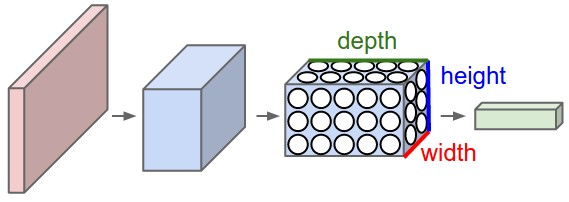

As a teaser, let's apply a convolutional network to the MNIST digit classification problem that we previously approached using a dense network.

In [32]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(filters=32, kernel_size=(3,3),
                       activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Conv2D(filters=64, kernel_size=(3,3),
                       activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Conv2D(filters=64, kernel_size=(3,3),
                       activation='relu'))

In [33]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 3, 3, 64)          36928     
Total params: 55,744
Trainable params: 55,744
Non-trainable params: 0
_________________________________________________________________


In [34]:
model.add(layers.Flatten())
model.add(layers.Dense(units=64, activation='relu'))
model.add(layers.Dense(units=10, activation='softmax'))

In [35]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_2 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                36928     
__________

In [36]:
from keras.datasets import mnist
from keras.utils import to_categorical

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [37]:
train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

model.compile(optimizer='rmsprop',
             loss='categorical_crossentropy',
             metrics=['accuracy'])
model.fit(x=train_images, y=train_labels, epochs=5, batch_size=64)

Epoch 1/5
60000/60000 [==============================] - 6s 107us/step - loss: 0.1673 - acc: 0.9485
Epoch 2/5
60000/60000 [==============================] - 6s 102us/step - loss: 0.0465 - acc: 0.9859
Epoch 3/5
60000/60000 [==============================] - 7s 109us/step - loss: 0.0317 - acc: 0.9900
Epoch 4/5
60000/60000 [==============================] - 6s 107us/step - loss: 0.0238 - acc: 0.9924
Epoch 5/5
60000/60000 [==============================] - 6s 104us/step - loss: 0.0187 - acc: 0.9942


In [38]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
test_acc

10000/10000 [==============================] - 1s 54us/step


0.9919

## The Convolution operation

The fundamental difference between a densely connected layer and a convolution layer is that dense layers learn global patterns in the input feature space (e.g. for an image, patterns involving all pixels), whereas convolutional layers learn local patterns. 

As a result, convolutional networks have two interesting properties.
* The patterns they learn are translation invariant
* They can learn spatial hierarchies of patterns

<div style="display:block;margin:auto;width:600px;">
    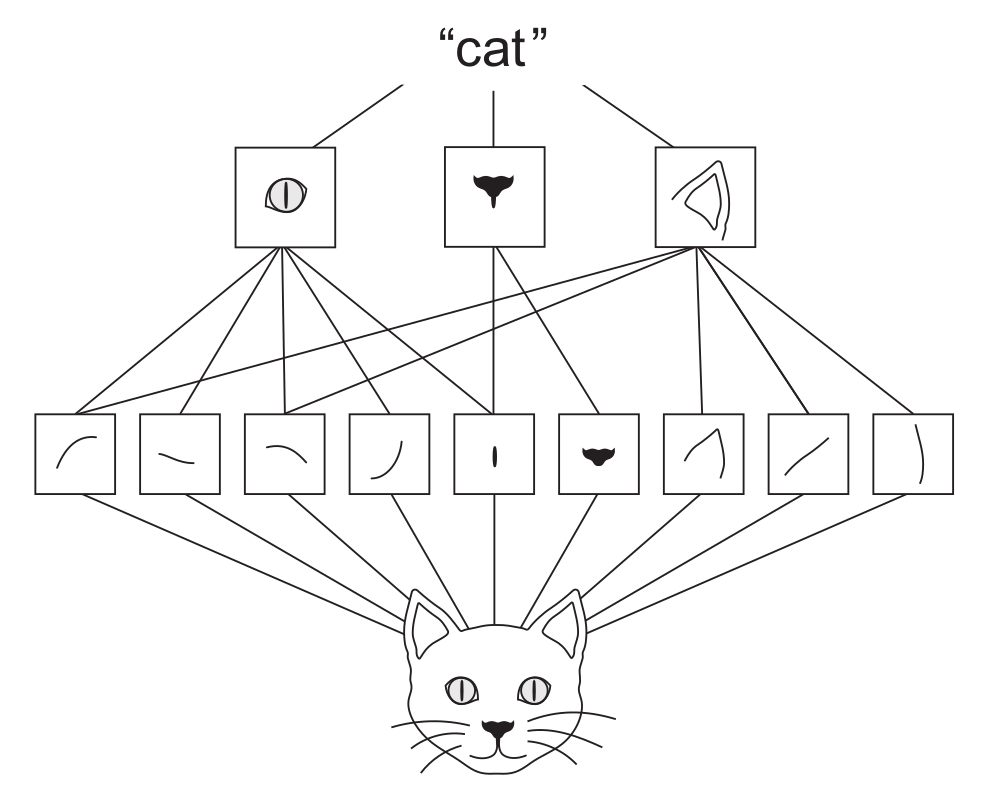
</div>
<div style="text-align:center;">**A spatial heirarchy of patterns**</div>

Convolutions operate over 3D tensors (*feature maps*) that represent images, with two spatial axes (*height* and *width*) as well as a depth axis (also called the *channels* axis), which typically represents intensities of color or shade channels at specific spatial locations.

The convolution operation typically moves over squares of the input tensor, and applies the same transformation to each of these squares, producing an *output feature map*. The output feature map is still a 3D tensor with a width and height, as well as depth. The depth of the output feature map no longer encodes colours, but is now a parameter of the network, where each additional depth dimension corresponds to the output of a convolution operation trained with different weights (a *filter*), and that is expected to learn to recognise different high-level concepts in the data (such as the presence of a labrador's floppy ears). 

Now for a little more on convolution operations, which are the key building blocks of convolutional neural networks. Convolutions are defined by two fundamental parameters:
* *Height and width of the squares operated on from the inputs* $3\times 3$ and $5\times 5$ are common choices. In general, larger squares can identify high level features, which smaller squares can identify lower level, local features.
* *Depth of the output feature map* The number of filters computed by the convolution.

In Keras, convolutions are implemented using (among others) `Conv2D` layers. The fundamental parameters mentioned above are the first arguments passed to the layer: `Conv2D(output_depth, (window_height, window_width))`.

A convolution works by moving the squares over the 3D input map, stopping at every possible location, and extracting the 3D rectangle of surrounding features (with shape `(square_height, square_width, input_depth)`). Each 3D rectangle is then transformed (via a 3D tensor product with the same learned weight matrix, called the *convolutional kernel*) into a 1D vector of shape `(output_depth,)`. All of the output vectors (corresponding to every possible position of the convolutional kernel) are then spatially reassempled into a 3D output map of shape `(height, width, output_depth)`. 


<div style="display:block;margin:auto;width:500px;">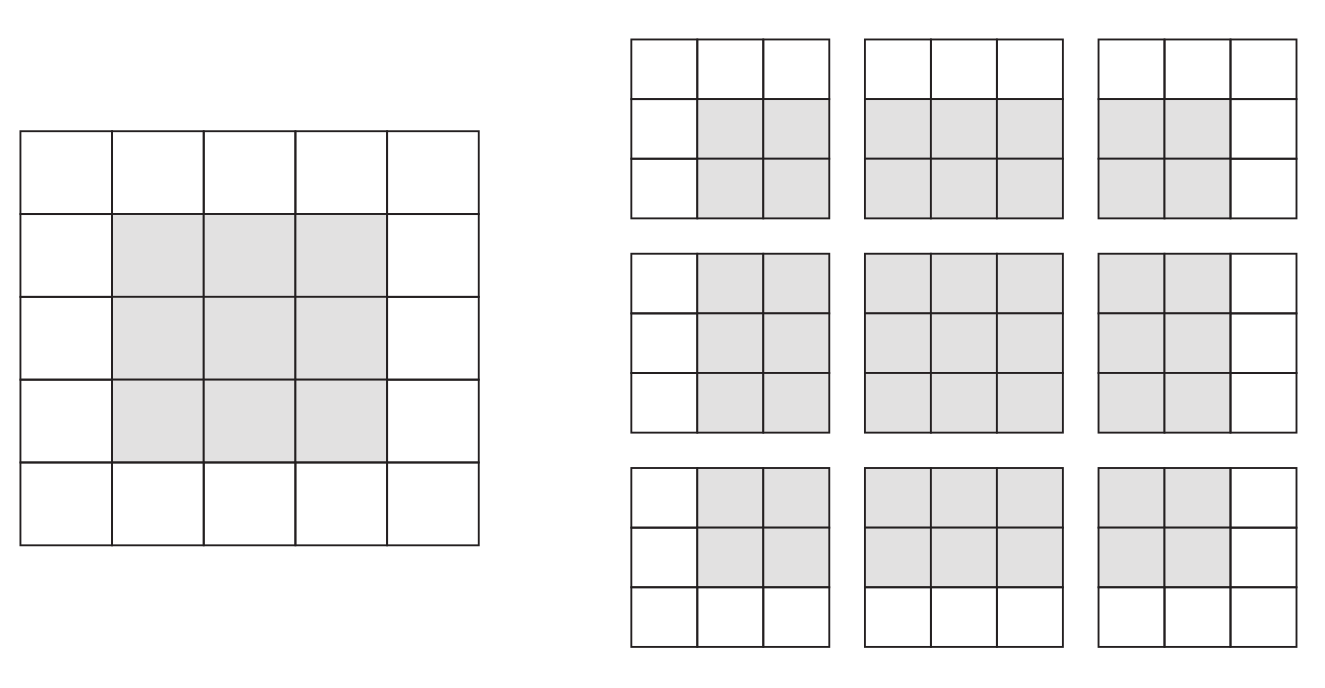</div>
<div style="text-align:center;">**Valid locations of 3 x 3 patches on a 5 x 5 input feature map**</div>

Consider the above 5 x 5 feature map. There are exactly 9 squares around which a 3 x 3 window can be centered, forming a 3 x 3 grid. The output feature map will therefore be 3 x 3. In other words, the input feature map has shrunk by 2 tiles along each dimension.

To obtain an output feature map with the same spatial dimensions as the input, *padding* is used. Padding consists of adding the appropriate number of rows and columns on each side of the input feature map to enable the convolution windows to be centered around each of the original input tiles. For a 3 x 3 window, columns of zeros are added to the left and right of the input feature map, and rows of zeros are added at the top and bottom of the input feature map.

<div style="display:block;margin:auto;width:600px;">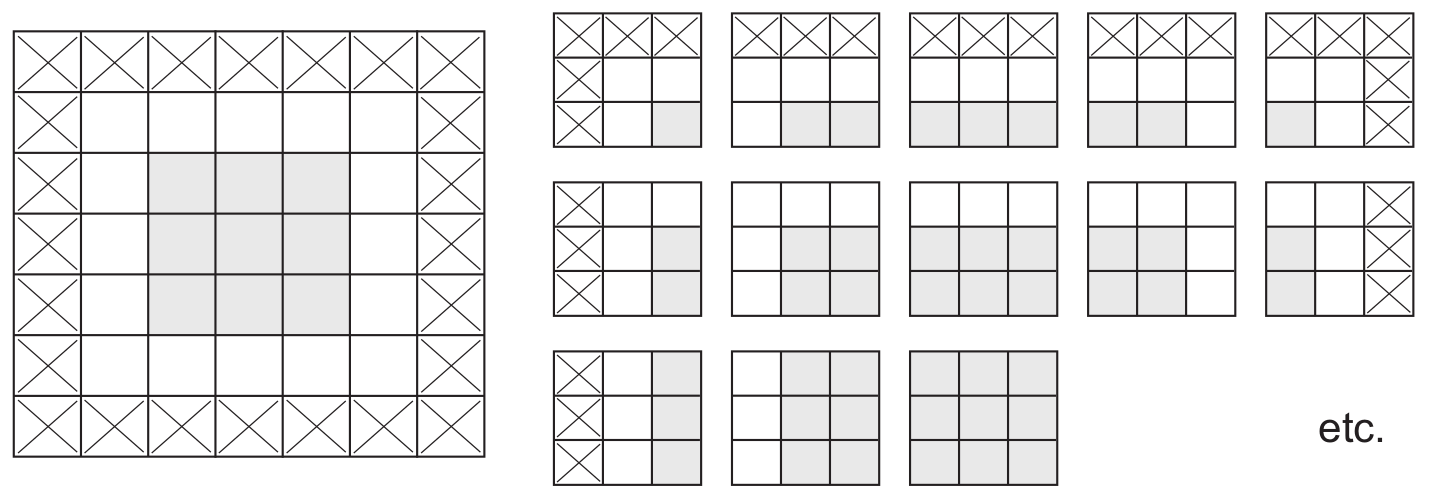</div>
<div style="text-align:center;">**Padding a 5 x 5 input feature map to extract the same size output map**</div>


In Keras `Conv2D` layers, the padding for a convolutional network can be controlled using the `padding` argument, which accepts two values: `valid`, which means no padding (as in the first example), and `same`, which means padding so that the output feature map has the same width and height as the input feature map.

In addition to applying padding, we can consider moving the convolution window centers by more than a single square each time. This is referred to as *strided convolutions*, where convolutions have a stride greater than 1.

<div style="display:block;margin:auto;width:600px;">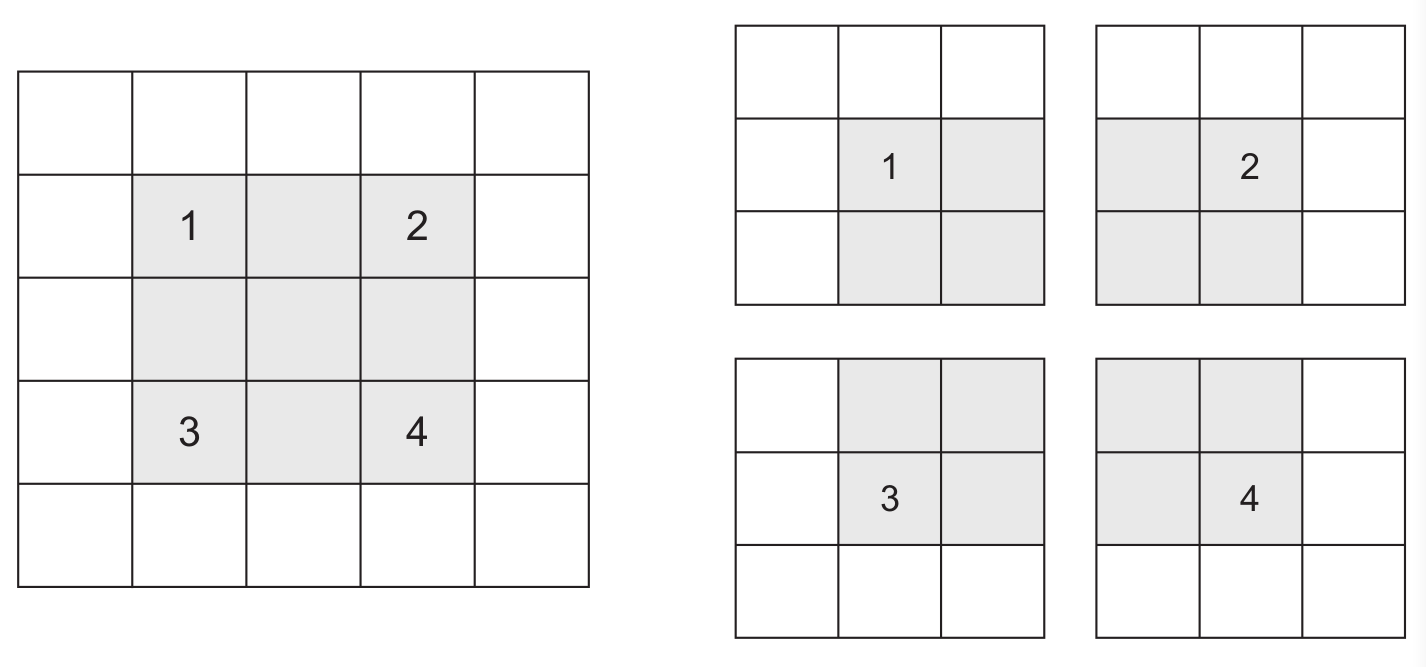</div>
<div style="text-align:center;">**3 x 3 convolutions with 2 x 2 strides**</div>

Using a stride of 2 means that the width and height of the output feature map are downsampled by a factor of 2. Strided convolutions are used less frequently in practice. 

For awesome visualizations of how convolutions work, [check out this Github repo](https://github.com/vdumoulin/conv_arithmetic).

<div style="display:block;margin:auto;width:600px;">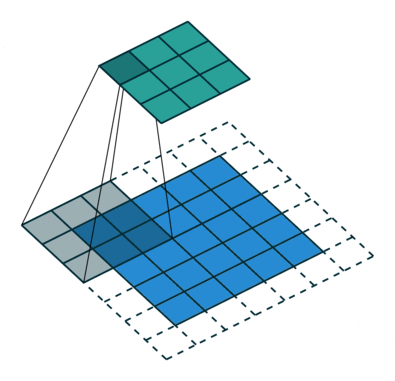</div>
<div style="text-align:center;">**Padding and strides animation**</div>

## Pooling

It is common to periodically insert a Pooling layer in-between successive Conv layers in a ConvNet architecture. Its function is to progressively reduce the spatial size of the representation to reduce the amount of parameters and computation in the network, and hence to also control overfitting. The Pooling Layer operates independently on every depth slice of the input and resizes it spatially, using the MAX operation. The most common form is a pooling layer with filters of size 2x2 applied with a stride of 2, which downsamples every depth slice in the input by 2 along both width and height, discarding 75% of the activations. Every MAX operation would in this case be taking a max over 4 numbers (little 2x2 region in some depth slice). 

<div style="display:block;margin:auto;width:600px;">
    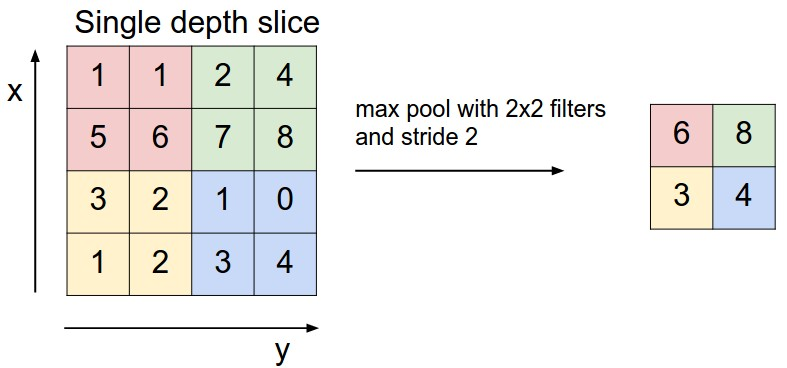
</div>
<div style="text-align:center;">**Max pooling visualization**</div>

The depth dimension remains unchanged. More generally, the pooling layer:

* Accepts a volume of size $W1×H1×D1$
* Requires two hyperparameters:
    * their spatial extent F,
    * the stride S,
* Produces a volume of size W2×H2×D2 where:
    * $W2=(W1−F)/S+1$
    * $H2=(H1−F)/S+1$
    * $D2=D1$
* Introduces zero parameters since it computes a fixed function of the input
* Note that it is not common to use zero-padding for Pooling layers

It is worth noting that there are only two commonly seen variations of the max pooling layer found in practice: A pooling layer with $F=3,S=2$ (also called overlapping pooling), and more commonly $F=2,S=2$. Pooling sizes with larger receptive fields are too destructive.

<div style="display:block;margin:auto;width:600px;">
    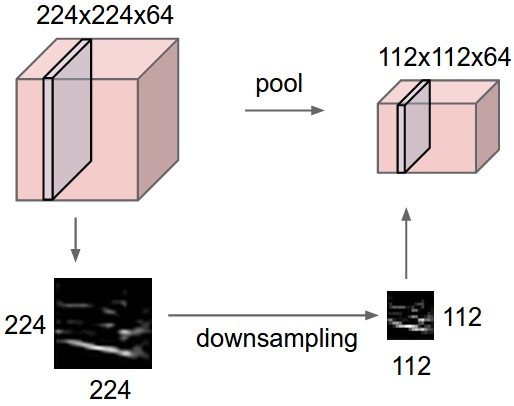
</div>
<div style="text-align:center;">**Pooling visualization**</div>



Download the Dogs vs Cats data:

In [1]:
import os, shutil
from tqdm import tqdm

original_dataset_dir = '/home/tim/Github/learning-materials/data'

# create a new directory for the subset of cat and dog images
base_dir = '/home/tim/Github/learning-materials/cats_and_dogs_small'
os.mkdir(base_dir)

# create base training, validation and test directories
def join_create_dir(base, suffix):
    """
    Join a base directory with a new folder name, creating the new
    directory and returning its path.
    
    :param base: base directory path
    :param suffix: folder to append
    """
    new_dir = os.path.join(base, suffix)
    os.mkdir(new_dir)
    return new_dir
train_dir = join_create_dir(base_dir, 'train')
validation_dir = join_create_dir(base_dir, 'validation')
test_dir = join_create_dir(base_dir, 'test')

# stratify these directories for cats and dogs
def split_cats_dogs(base):
    """
    Stratifies a base directory into subdirectories for cats and dogs.
    
    :param base: base directory for which to create subdirectories
    """
    cats_dir = os.path.join(base, 'cats')
    os.mkdir(cats_dir)
    dogs_dir = os.path.join(base, 'dogs')
    os.mkdir(dogs_dir)
    return cats_dir, dogs_dir
train_cats_dir, train_dogs_dir = split_cats_dogs(train_dir)
validation_cats_dir, validation_dogs_dir = split_cats_dogs(validation_dir)
test_cats_dir, test_dogs_dir = split_cats_dogs(test_dir)

def move_files(animal, min, max, datatype):
    """
    Move a subset of images into the relavant subdir for cats or dogs.
    
    :param animal: cat or dog
    :param min: min image index
    :param max: max immage index
    :param datatype: train, validation or test set
    """
    fnames = ['{}.{}.jpg'.format(animal, i) for i in range(min, max)]
    pbar = tqdm(range(min, max), desc=f'copying {animal}s')
    for fname in fnames:
        src = os.path.join(original_dataset_dir, fname)
        dst = os.path.join(eval(f'{datatype}_{animal}s_dir'), fname)
        shutil.copyfile(src, dst)
        pbar.update()
    pbar.close()
    
# create all the data directories for cats
move_files('cat', 0, 1000, 'train')                           
move_files('cat', 1000, 1500, 'validation')                           
move_files('cat', 1500, 2000, 'test')                           

# create all the data directories for dogs
move_files('dog', 0, 1000, 'train')                           
move_files('dog', 1000, 1500, 'validation')                           
move_files('dog', 1500, 2000, 'test')                           

copying dogs: 100%|██████████| 500/500 [00:00<00:00, 8530.70it/s]


Lets check that we have all the expected images:

In [2]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))
print('total test cat images:', len(os.listdir(test_cats_dir)))
print('total test dog images:', len(os.listdir(test_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
total test cat images: 500
total test dog images: 500


Creat the Convolutional model in as a Keras sequential model.

In [4]:
from keras import layers
from keras import models


model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [5]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 15, 15, 128)       147584    
__________

In [6]:
from keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [7]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
            train_dir,
            target_size=(150, 150),
            batch_size=20,
            class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
            validation_dir,
            target_size=(150, 150),
            batch_size=20,
            class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [8]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 150, 150, 3)
labels batch shape: (20,)


In [9]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch=100,
        epochs=10,
        validation_data=validation_generator,
        validation_steps=50)

Epoch 1/10
100/100 [==============================] - 14s 142ms/step - loss: 0.6865 - acc: 0.5405 - val_loss: 0.6702 - val_acc: 0.5860
Epoch 2/10
100/100 [==============================] - 12s 122ms/step - loss: 0.6522 - acc: 0.6260 - val_loss: 0.6709 - val_acc: 0.5780
Epoch 3/10
100/100 [==============================] - 13s 126ms/step - loss: 0.6063 - acc: 0.6765 - val_loss: 0.6359 - val_acc: 0.6310
Epoch 4/10
100/100 [==============================] - 12s 123ms/step - loss: 0.5650 - acc: 0.7100 - val_loss: 0.6009 - val_acc: 0.6730
Epoch 5/10
100/100 [==============================] - 13s 128ms/step - loss: 0.5256 - acc: 0.7360 - val_loss: 0.6029 - val_acc: 0.6620
Epoch 6/10
100/100 [==============================] - 12s 123ms/step - loss: 0.5018 - acc: 0.7540 - val_loss: 0.5793 - val_acc: 0.6890
Epoch 7/10
100/100 [==============================] - 12s 125ms/step - loss: 0.4746 - acc: 0.7780 - val_loss: 0.5801 - val_acc: 0.6810
Epoch 8/10
100/100 [==============================] - 1

In [13]:
model.save('cats_and_dogs_small_2.h5')

Lets take a look at the loss curves to see the progress of the training

In [14]:
%matplotlib inline
from utils import show_plots

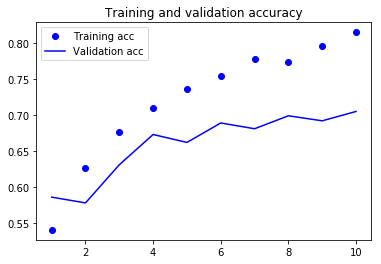

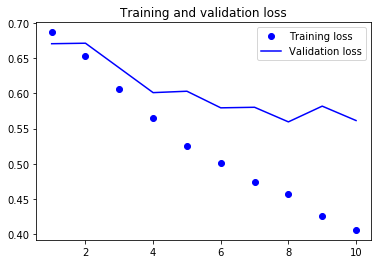

In [15]:
show_plots(history.history['acc'],
           history.history['val_acc'],
           history.history['loss'],
           history.history['val_loss'])

## Pretrained networks for image classification

A very effective approach in deep learning for small image datasets is the use of a pretrained network. A pretrained network is a neural network that was trained on a large data set, typically also in an image classification task. If the original dataset is large and general enough, then the hierarchy of features that the pretrained network has learned can effectively model high-level patterns across a wide range of images, even images that are completely unrelated to the original task.

This is a specific case of *transfer learning*: the improvement of learning in a new task through the transfer of knowledge from a related task that has already been learned. For instance, large-scale image recognition networks have even been fine-tuned to predict word vectors, and even other images (see [this lecture](https://www.youtube.com/watch?v=uv0gmrXSXVg&list=PLrEfYvG1JxFqR_l3mFUpHg_AtzWoY32p1&index=17) from the hugely innovative folks at Fast.AI).

Here lets consider a large convnet trained on the ImageNet dataset (1.4 million labelled images and 1000 different classes), which incidentallly contains images of many different breeds of cats and dogs, and can be expected to generalize well to the cats vs dogs classufication problem.

We'll use the VGG16 architecture from 2014, developed by Karen Simonyan and Andrew Zisserman. 

<div style="display:block;margin:auto;width:600px;">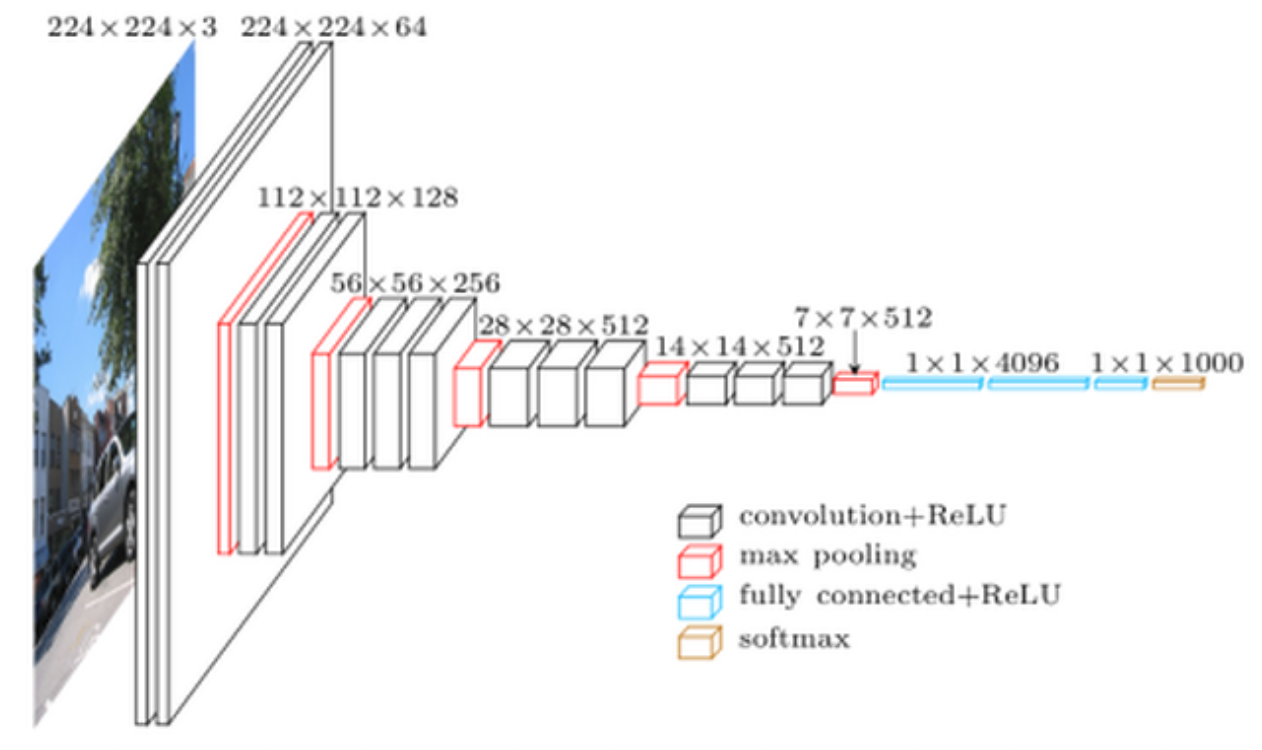</div>
<div style="text-align:center;">**VGG16 Architecture**</div>

### Feature extraction

Feature extraction consists of using the representations learned by a previous network to extract relevant features from the new samples. These features then fees into a new classifier, which is trained from scatch.

As we have seen in the convolutional networks that we have built from scratch, convnets for image classification consist of two basic building blocks:
1. Multiple convolution and pooling layers
2. A densely connected classifier

The convolutional part of the network is likely to represent the most generic features for modelling. One important motivation for this observation is that the densely connected layer feeding into the classifcation will necessarily be specific to the set of classes on which the model was trained. Remember— a core objective of transfer learning is to alter or completely replace the original set of classes! Regarding the convolutional layers, the generality of features learned by different parts of the network is important to our choice of which parts of the network to re-use. 

Layers that occur early in the model tend to extract generic feature maps (such as edges, colours and textures), which layers that occur layer in the network tend to extract higer-level, abstract features (check out this awesome [Distil.pub](https://distill.pub/2018/building-blocks/) page on some of the features learned by large convolutional models). If the new dataset for transfer learning differs significantly from the original dataset or task on which the model was trained, it may be beneficial to use only the early-stage convolutional layers of the model (as the more abstract features are more domain specific).

<div style="display:block;margin:auto;width:600px;">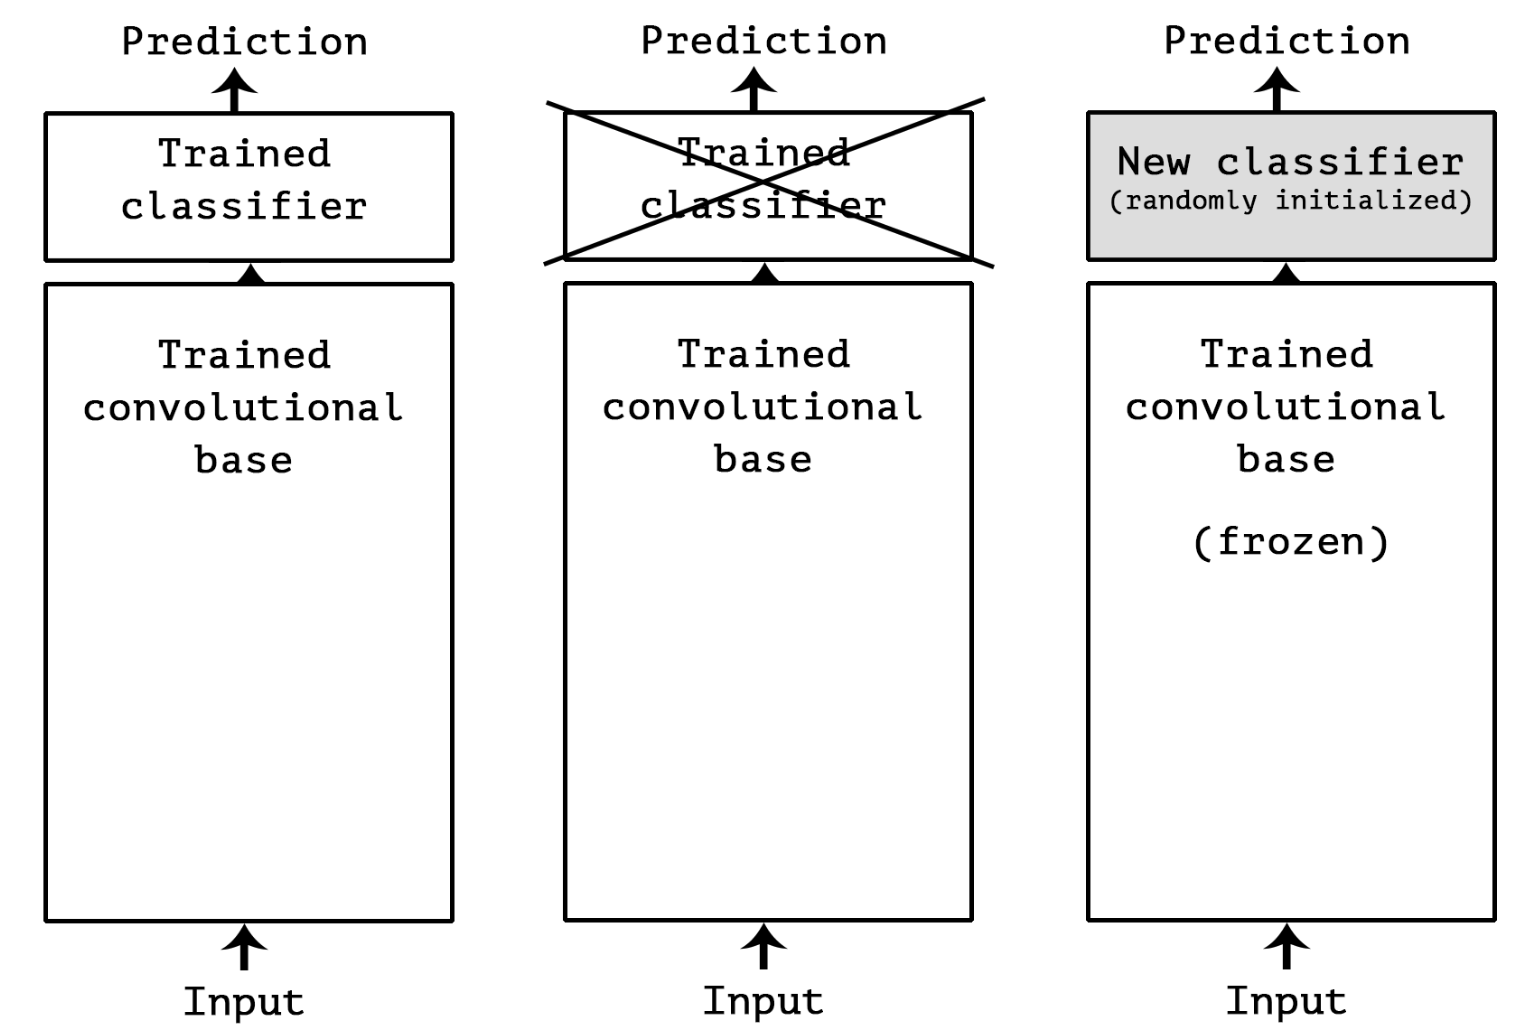</div>
<div style="text-align:center;">**Convolutional transfer learning schematic**</div>

Lets go ahead and get started with repurposing the VGG16 model.

In [3]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

The arguments passed to the constructor for the VGG16 network are interpreted as follows:
* `weights` specifies the weight checkpoint from which to initialize the model
* `include_top` controls whether the dense classifier on top of the netwok is included
* `input_shape` refers to the shape of the image tensors that will be fed into the network

Here's a closer look at the architecture:

In [4]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

We're going to go ahead with fast feature extraction. We'll start by running instances of the previously introduced `ImageDataGenerator` through the convolutional base of VGG16 to obtain feature representations of images as Numpy arrays as well as their labels. We'll extract features from these images by calling the predict method of the `conv_base` model.

Note that this is a fast and computationally efficient approach to the problem, as it requires no re-training of the convolutional base, and, once features have been extracted, requires only for the final densely-connected layer to be trained.

In [4]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm_notebook as tqdm

base_dir = '/home/tim/Github/learning-materials/cats_and_dogs_small'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    pbar = tqdm(range(sample_count // batch_size))
    for inputs_batch, labels_batch in generator:
        # compute features for input images in batch
        features_batch = conv_base.predict(inputs_batch)
        # store the computed features and labels in larger Numpy arr
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
        pbar.update()
    pbar.close()
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.



Found 1000 images belonging to 2 classes.



Found 1000 images belonging to 2 classes.


In [5]:
print(train_features.shape)
print(validation_features.shape)
print(test_features.shape)

(2000, 4, 4, 512)
(1000, 4, 4, 512)
(1000, 4, 4, 512)


The extracted features are currently of shape `(samples, 4, 4, 512)`. We will feed them to a densely-connected classifier, so first we must flatten them to `(samples, 8192)`:

In [6]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [7]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6371 - acc: 0.6480 - val_loss: 0.4511 - val_acc: 0.8330
Epoch 2/30
2000/2000 [==============================] - 3s 2ms/step - loss: 0.4260 - acc: 0.8185 - val_loss: 0.3745 - val_acc: 0.8430
Epoch 3/30
2000/2000 [==============================] - 3s 1ms/step - loss: 0.3639 - acc: 0.8450 - val_loss: 0.3316 - val_acc: 0.8640
Epoch 4/30
2000/2000 [==============================] - 3s 1ms/step - loss: 0.3223 - acc: 0.8645 - val_loss: 0.3027 - val_acc: 0.8840
Epoch 5/30
2000/2000 [==============================] - 3s 1ms/step - loss: 0.2932 - acc: 0.8815 - val_loss: 0.2876 - val_acc: 0.8920
Epoch 6/30
2000/2000 [==============================] - 3s 1ms/step - loss: 0.2724 - acc: 0.8955 - val_loss: 0.2802 - val_acc: 0.8840
Epoch 7/30
2000/2000 [==============================] - 3s 1ms/step - loss: 0.2538 - acc: 0.9005 - val_loss: 0.2679 - val_acc: 0.8990
Epoch 8/30
200

In [9]:
model.inputs

[<tf.Tensor 'dense_1_input:0' shape=(?, 8192) dtype=float32>]

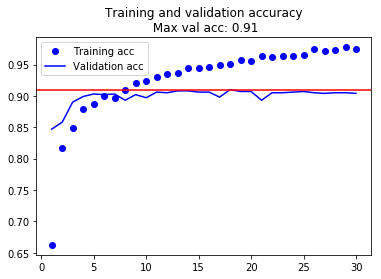

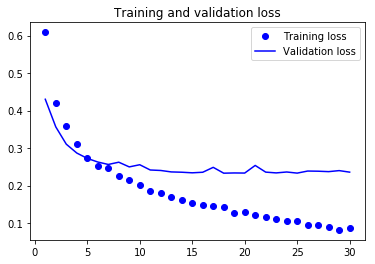

In [11]:
% matplotlib inline
from utils import show_plots

show_plots(history.history['acc'],
           history.history['val_acc'],
           history.history['loss'],
           history.history['val_loss'])

This is impressive performance at very little computational expense! 

If we want to leverage data augmentation, which is very useful in preventing overfitting in small datasets, we'll need to run the convolutional base with the densely-connected classifier end-to-end on the inputs.

Using the Keras API, a model can be addded to a sequential model just as a layer usually would:

In [5]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


VGG16 has about 14 million trainable parameters! Before compiling and training, we need to freeze the convolutional base. This prevents the weights and biases in the convolutional base from being updated during training.

If we didn't freeze the convolutional base, the representations previously learned by VGG16 would be modified during training (additionally, training would be even more computationally expensive). Since the Dense layers on top are randomly initialized, very large weight updates would be propagated through the network, effectively destroying the representations previously learned.

In [7]:
conv_base.trainable = False

In [8]:
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


# Visualizing Convnet learning

In [2]:
from keras.models import load_model

model = load_model('cats_and_dogs_small_2.h5')
model.summary()  # As a reminder.

/home/tim/.python3.6.4_general/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/tim/.pyenv/versions/3.6.4/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 15, 15, 128)       147584    
__________

In [3]:
img_path = '/home/tim/Github/learning-materials/cats_and_dogs_small/test/cats/cat.1700.jpg'

# We preprocess the image into a 4D tensor
from keras.preprocessing import image
import numpy as np

img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
# Remember that the model was trained on inputs
# that were preprocessed in the following way:
img_tensor /= 255.

# Its shape is (1, 150, 150, 3)
print(img_tensor.shape)

(1, 150, 150, 3)


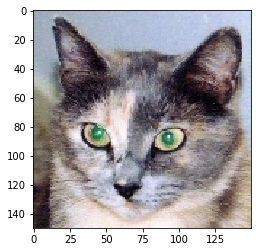

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(img_tensor[0])
plt.show()

In order to extract the feature maps we want to look at, we will create a Keras model that takes batches of images as input, and outputs 
the activations of all convolution and pooling layers. To do this, we will use the Keras class `Model`. A `Model` is instantiated using two 
arguments: an input tensor (or list of input tensors), and an output tensor (or list of output tensors). The resulting class is a Keras 
model, just like the `Sequential` models that you are familiar with, mapping the specified inputs to the specified outputs. What sets the 
`Model` class apart is that it allows for models with multiple outputs, unlike `Sequential`.

In [5]:
from keras import models

# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in model.layers[:8]]
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

When fed an image input, this model returns the values of the layer activations in the original model. This is the first time we've dealt with a multi-output model: until now the models you have seen only had exactly one input and one output. In the general case, a 
model could have any number of inputs and outputs. This one has one input and 8 outputs, one output per layer activation.

In [6]:
# This will return a list of 5 Numpy arrays:
# one array per layer activation
activations = activation_model.predict(img_tensor)

For instance, this is the activation of the first convolution layer for our cat image input:

In [7]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 148, 148, 32)


It's a 148x148 feature map with 32 channels. Let's try visualizing the 3rd channel:

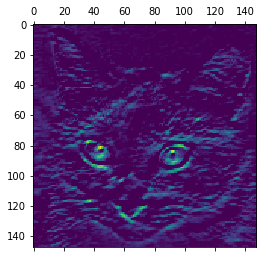

In [8]:
import matplotlib.pyplot as plt

plt.matshow(first_layer_activation[0, :, :, 3], cmap='viridis')
plt.show()

This channel appears to encode a diagonal edge detector. Let's try the 4th channel -- but note that your own channels may vary, since the 
specific filters learned by convolution layers are not deterministic.

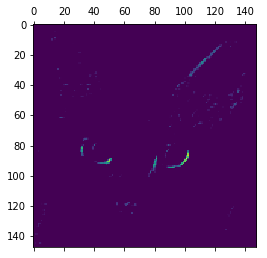

In [15]:
plt.matshow(first_layer_activation[0, :, :, 4], cmap='viridis')
plt.show()

At this point, let's go and plot a complete visualization of 
all the activations in the network. We'll extract and plot every channel in each of our 8 activation maps, and we will stack the results in 
one big image tensor, with channels stacked side by side.

/home/tim/.python3.6.4_general/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


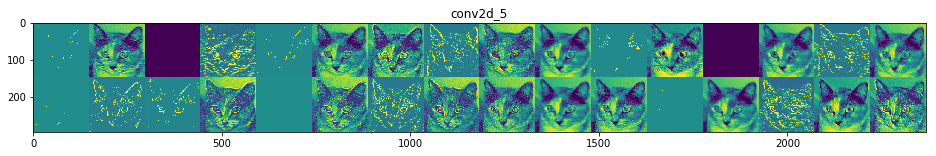

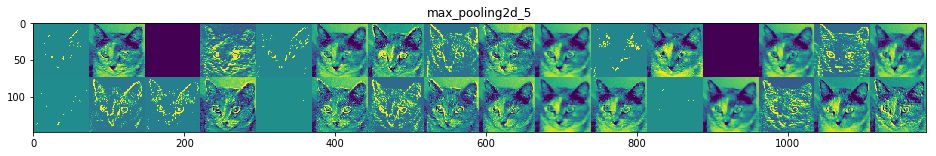

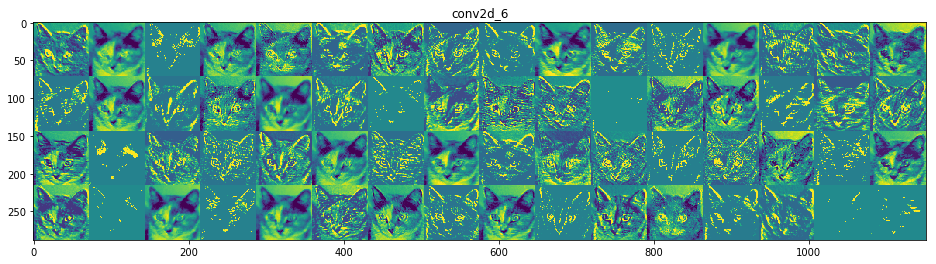

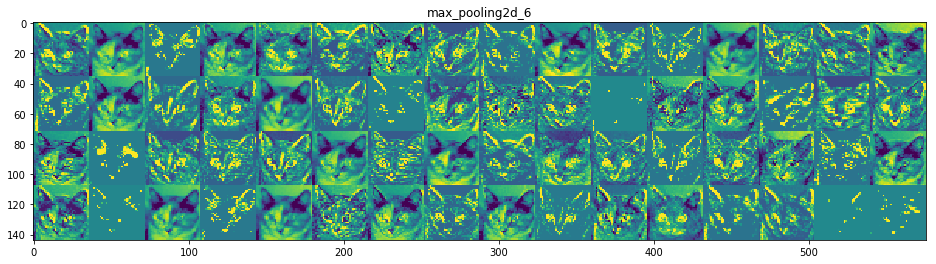

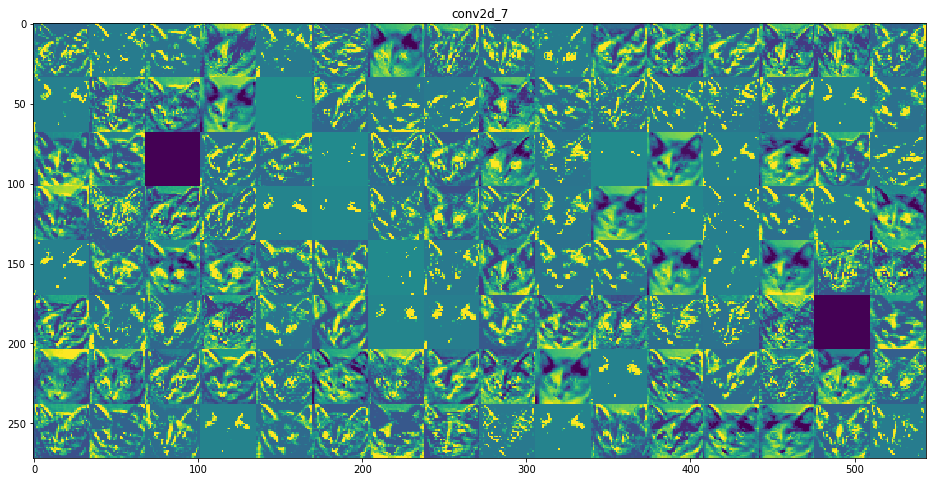

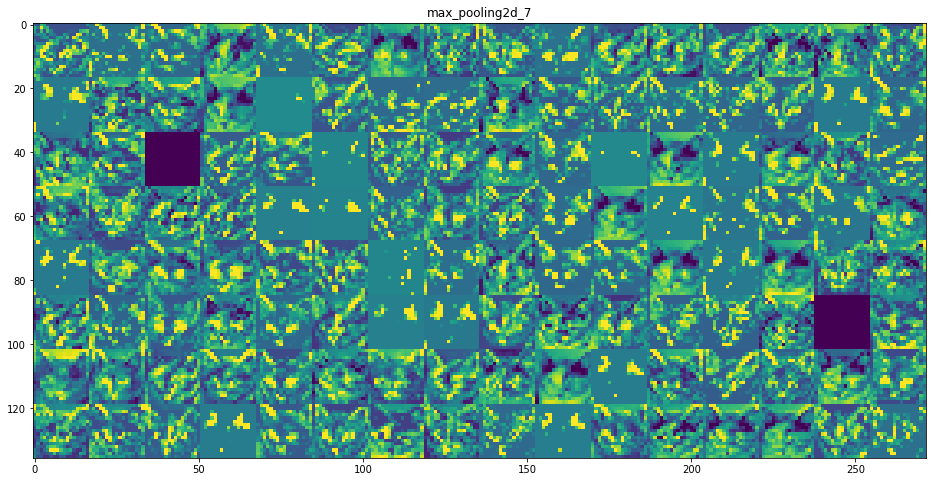

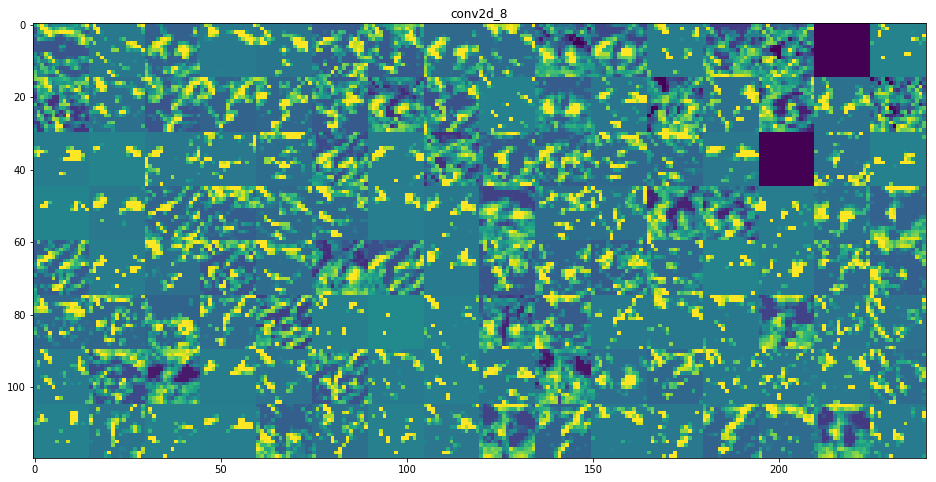

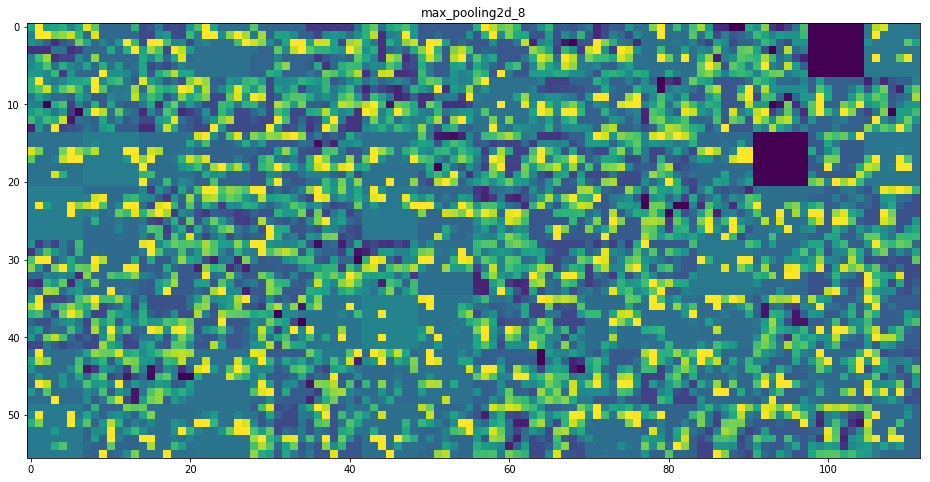

In [16]:
import keras

# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show()